# Проект. Улучшение baseline-модели
**Задача проекта улучшить основную метрику модели, которая влияет на точность предсказаний стоимости недвижимости**

Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) выполнены в этом Jupyter Notebook:

- Этап 2 - Исследовательский анализ данных (EDA): На этом мы проведем тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация признаков и обучение модели: после анализа мы сгенерируем новые признаки и обучим модель, используя эти признаки.

- Этап 4 - Отбор признаков и обучение модели: на этом шаге мы отберем наиболее значимые признаки и снова обучим модель для улучшения ее качества.

- Этап 5 - Подбор гиперпараметров и обучение финальной версии модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.


Загрузим основные библиотеки и обозначим константы для дальнейшей работы.

In [ ]:
import os
from dotenv import load_dotenv
import json
from pylab import rcParams
import time

import pathlib
import pandas as pd
import random
import numpy as np
import mlflow
from mlflow import MlflowClient
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    KBinsDiscretizer,
    OneHotEncoder,
)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from autofeat import AutoFeatRegressor

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration.mlflow import MLflowCallback

rcParams["figure.figsize"] = 9, 5
sns.set_style("white")
sns.set_theme(style="whitegrid", palette="flare")

SEED = 777
np.random.seed(777)
random.seed(777)

load_dotenv()

Сразу напишем функцию разделения данных для работы.

In [2]:
def split(data_x: pd.DataFrame, data_y, test_size=0.15):
    X_tr, X_tst, y_tr, y_tst = train_test_split(
        data_x, data_y, test_size=test_size, random_state=SEED
    )
    return X_tr, X_tst, y_tr, y_tst

## Этап 2: Исследовательский Анализ Данных (EDA)


### 2.1 Загрузка данных

Определим папку для сохранения артефактов со стадии EDA

In [3]:
ARTIF_EDA = "artif_eda"
if not os.path.exists(ARTIF_EDA):
    os.makedir(ARTIF_EDA)

Загрузим данные

In [4]:
data_path = pathlib.Path(
    "/home/mle-user/mle_projects/project-sprint-1/mle-project-sprint-1-v001/part2_dvc/data/initial_data.csv"
)

In [5]:
data = pd.read_csv(data_path)

### 2.2. Общий обзор датасета

Посмотрим на основные характеристики датасета

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100935 entries, 0 to 100934
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   floor              100935 non-null  int64  
 1   is_apartment       100935 non-null  bool   
 2   kitchen_area       100935 non-null  float64
 3   living_area        100935 non-null  float64
 4   rooms              100935 non-null  int64  
 5   total_area         100935 non-null  float64
 6   target             100935 non-null  int64  
 7   build_year         100935 non-null  int64  
 8   building_type_int  100935 non-null  int64  
 9   latitude           100935 non-null  float64
 10  longitude          100935 non-null  float64
 11  ceiling_height     100935 non-null  float64
 12  flats_count        100935 non-null  int64  
 13  floors_total       100935 non-null  int64  
 14  has_elevator       100935 non-null  bool   
dtypes: bool(2), float64(6), int64(7)
memory usage: 10.2

In [7]:
data.head()

floor  is_apartment  kitchen_area  living_area  rooms  total_area   
0      9         False          9.90    19.900000      1   35.099998  \
1      9         False          9.00    32.000000      2   56.000000   
2      1         False         10.10    43.099998      3   76.000000   
3      3         False          3.00    14.000000      1   24.000000   
4      1         False          6.18    29.340000      2   44.520000   

     target  build_year  building_type_int   latitude  longitude   
0   9500000        1965                  6  55.717113  37.781120  \
1  13500000        2000                  4  55.740040  37.761742   
2  20000000        2002                  4  55.672016  37.570877   
3   5200000        1971                  1  55.808807  37.707306   
4   9500000        1964                  4  55.795589  37.722622   

   ceiling_height  flats_count  floors_total  has_elevator  
0            2.64           84            12          True  
1            2.70           80            10          True  
2            2.64          771            17          True  
3            2.60          208             9          True  
4            2.64          180             5         False

Проверим наличие дубликатов

In [8]:
f"Количество дубликатов в  данных = {data.duplicated().sum()}"

'Количество дубликатов в  данных = 0'

Для удобства последующей работы переведем формат данных из `bool` в `int`, а также вернем столбцу `building_type_int` формат `category`

In [9]:
data = data.astype(
    {"building_type_int": "category", "is_apartment": "int", "has_elevator": "int"}
)

### 2.3 Анализ признаков для модели

#### 2.3.1 Построим распределение данных во всех признаков по отдельности.

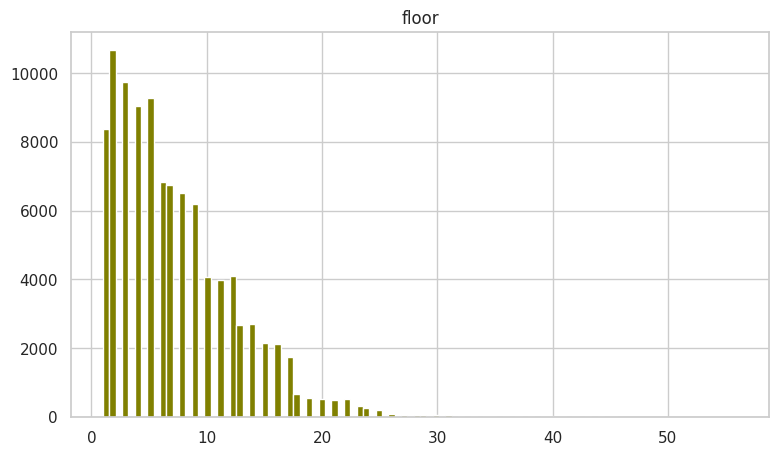

Unique values of floor - 51


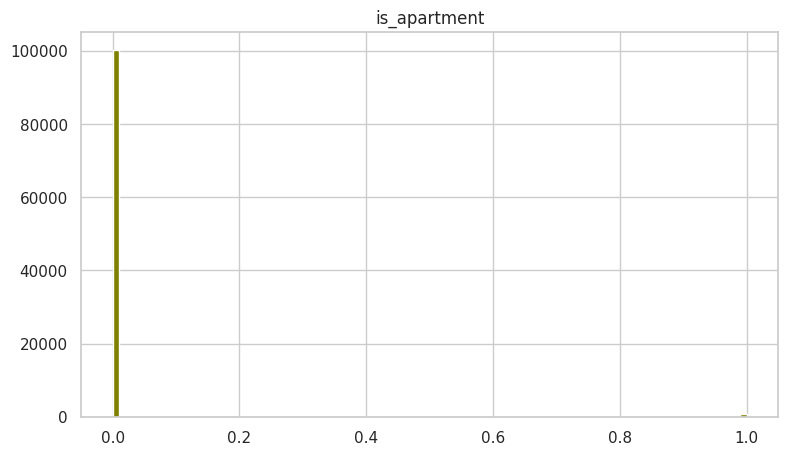

Unique values of is_apartment - 2


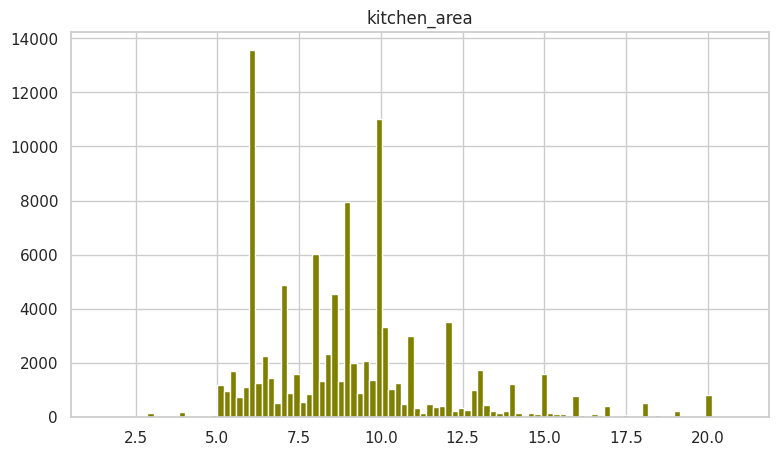

Unique values of kitchen_area - 711


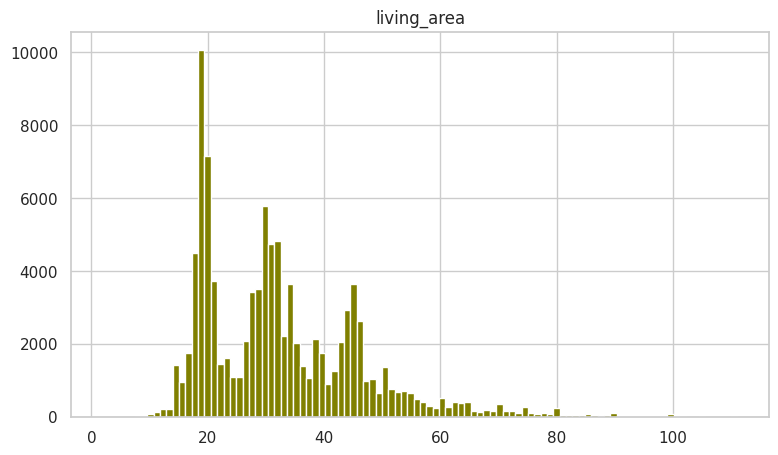

Unique values of living_area - 1756


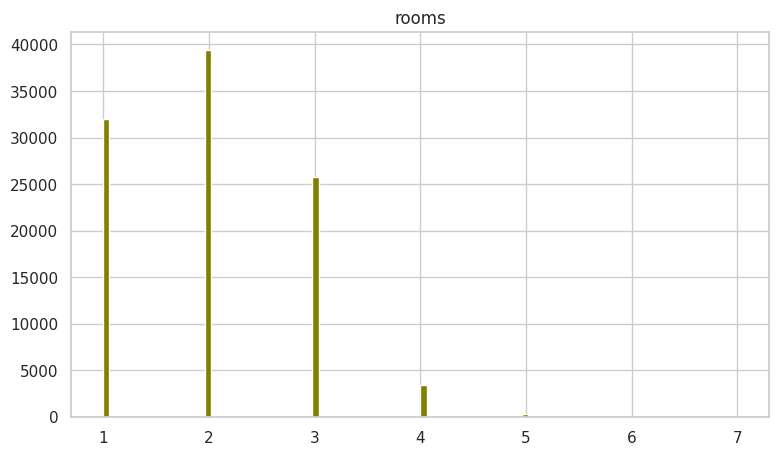

Unique values of rooms - 7


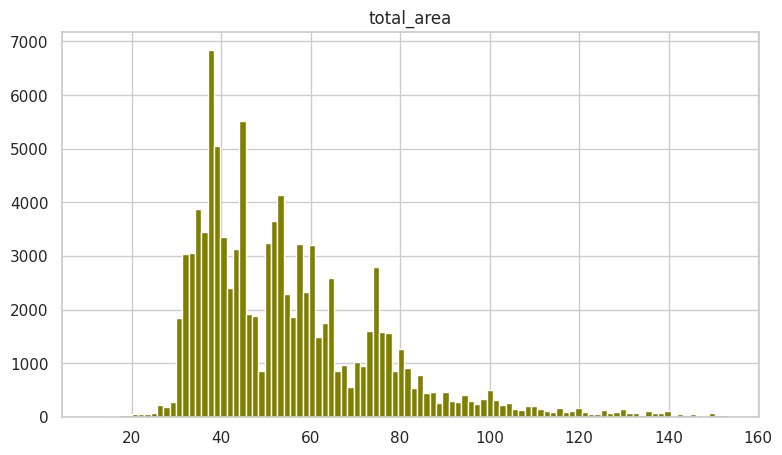

Unique values of total_area - 2130


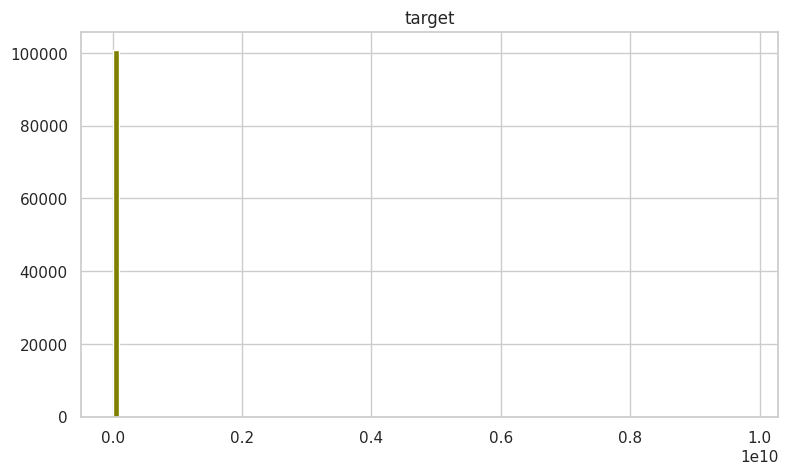

Unique values of target - 4690


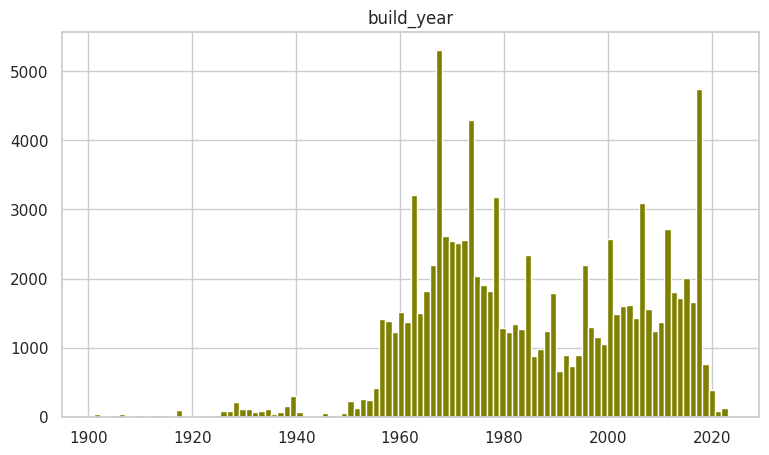

Unique values of build_year - 118


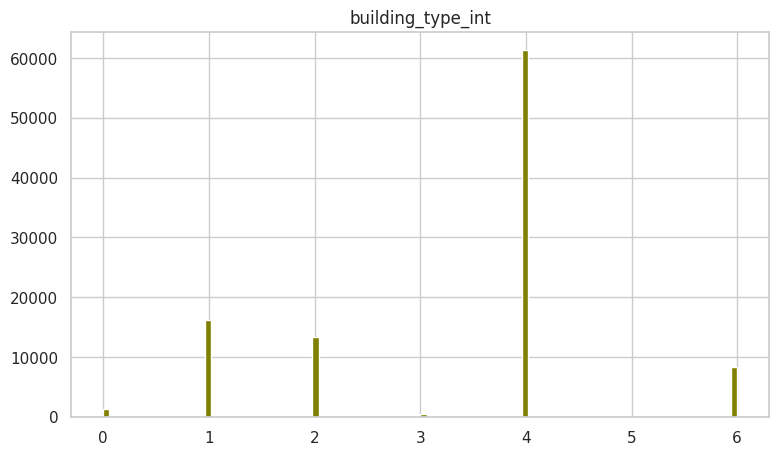

Unique values of building_type_int - 7


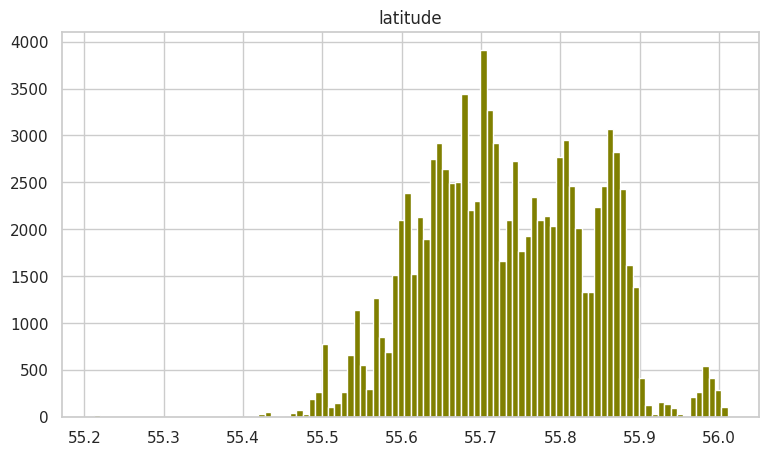

Unique values of latitude - 15113


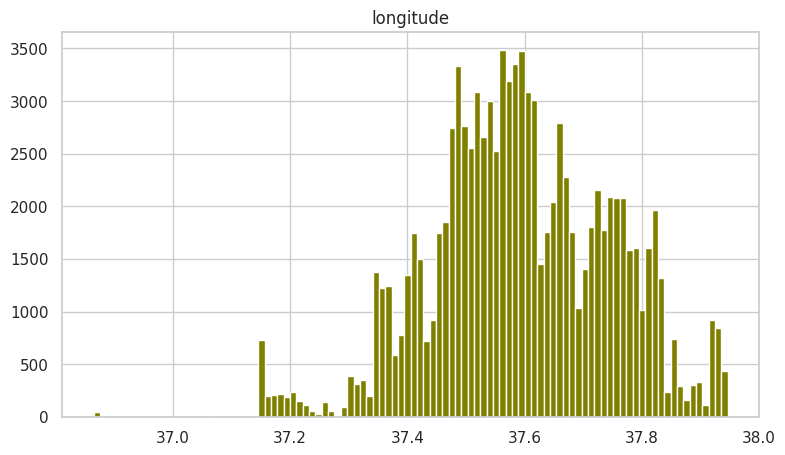

Unique values of longitude - 14706


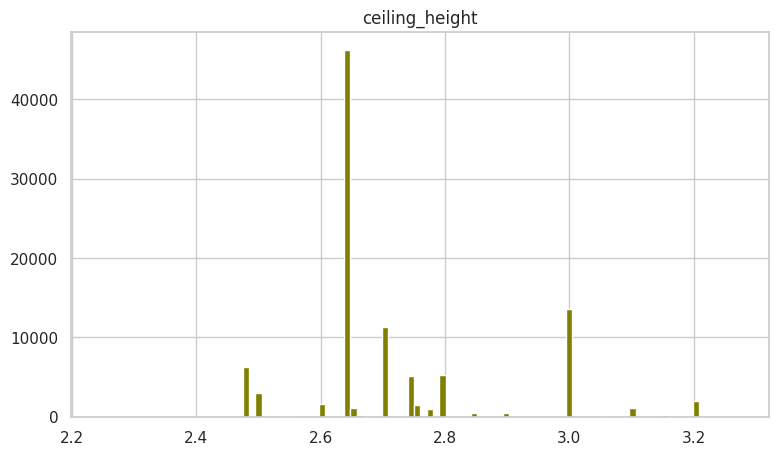

Unique values of ceiling_height - 49


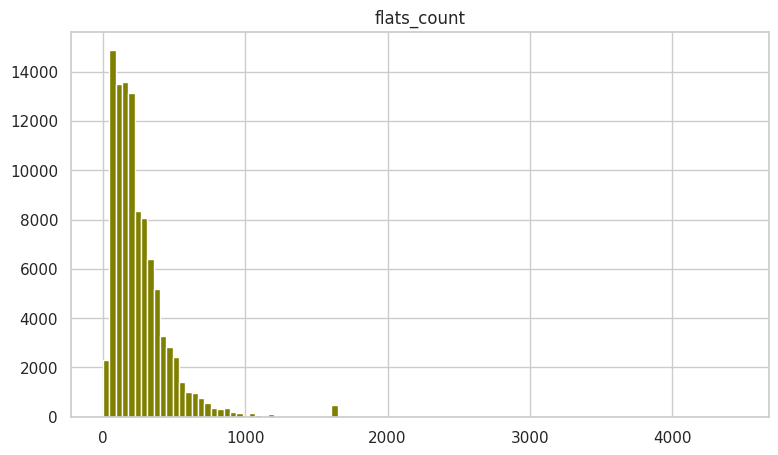

Unique values of flats_count - 706


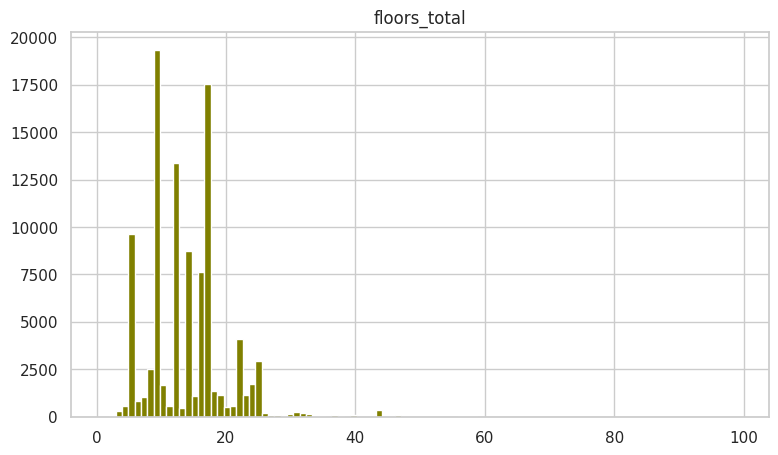

Unique values of floors_total - 59


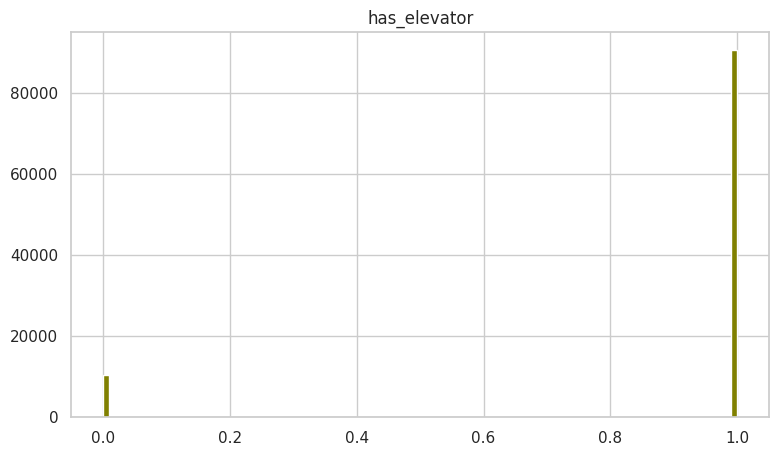

Unique values of has_elevator - 2


<Figure size 900x500 with 0 Axes>

In [11]:
for col in data.columns:
    data[col].hist(bins=100, color="olive")
    plt.title(col)
    plt.show()
    print(f"Unique values of {col} - {data[col].nunique()}")

plt.savefig(os.path.join(ARTIF_EDA, "fig2_3_1"))
plt.show()

#### 2.3.2 Посмотрим на корреляцию в имеющихся данных

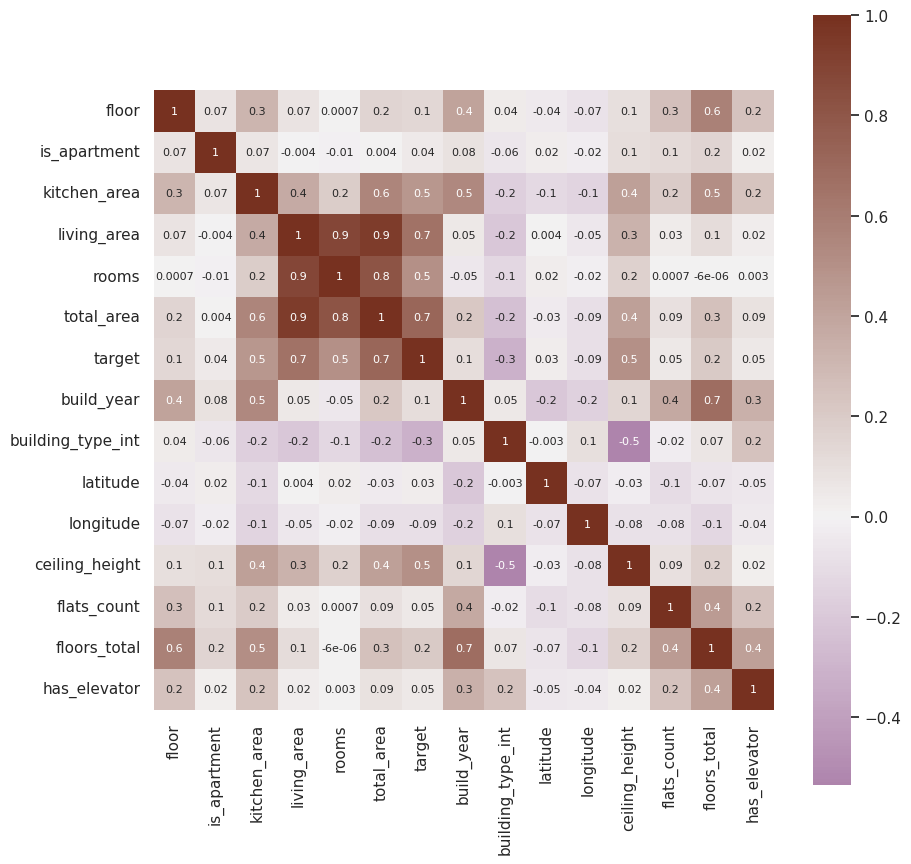

In [12]:
df = data[data["target"] < 100_000_000]

fig = plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(310, 20, l=30, as_cmap=True)
sns.heatmap(
    df.corr(),
    annot=True,
    fmt=".1g",
    square=True,
    annot_kws={"fontsize": 8},
    cmap=cmap,
    center=0,
)
plt.savefig(os.path.join(ARTIF_EDA, "fig2_3_2"))
plt.show()

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project2/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable target is large: 4611. Are you sure this is not an interval variable? Analysis for pairs of variables including target can be slow.
  warnings.warn(


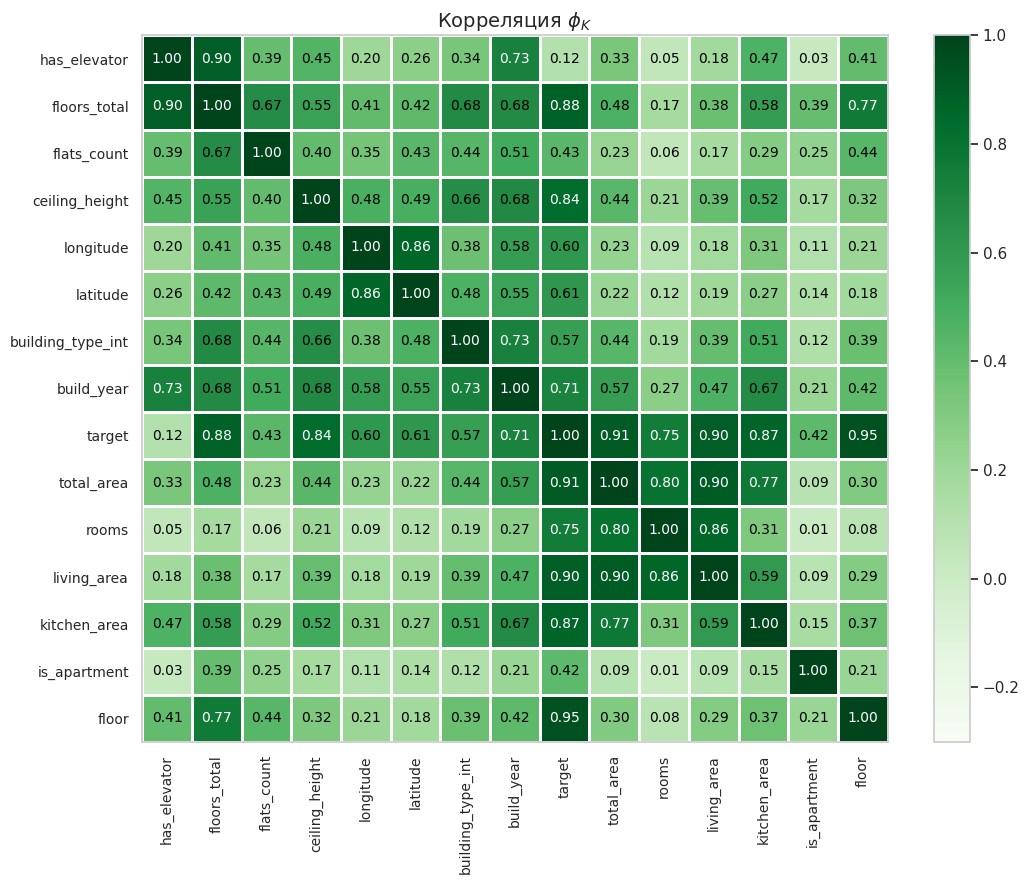

In [13]:
phik_matrix = phik.phik_matrix(
    df,
    interval_cols=[
        "kitchen_area",
        "living_area",
        "total_area",
        "latitude",
        "longitude",
        "ceiling_height",
        "flats_count",
        "floors_total",
        "build_year",
    ],
    bins=30,
)


phik.report.plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    figsize=(11, 9),
    color_map="Greens",
    title="Корреляция $\phi_K$ ",
    vmin=-0.3,
);

#### 2.3.3 Построим график изменения средних значений жилой площади и площади кухни в зависимости от общей площиди квартиры.

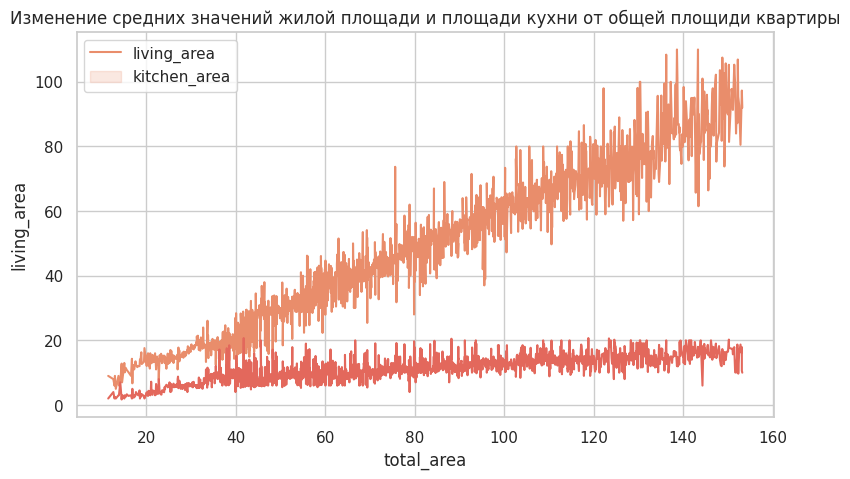

In [14]:
df = (
    data.groupby("total_area")[["kitchen_area", "living_area"]]
    .agg("mean")
    .reset_index()
)
ax = sns.lineplot(df, x="total_area", y="living_area")
sns.lineplot(df, x="total_area", y="kitchen_area", ax=ax)
ax.set(
    title="Изменение средних значений жилой площади и площади кухни от общей площиди квартиры"
)
ax.legend(["living_area", "kitchen_area"])

plt.savefig(os.path.join(ARTIF_EDA, "fig2_3_3"))
plt.show()

#### 2.3.4<a id='1'></a> Посмотрим в какие года были построены разные типы домов и как это влияет на их общую этажность

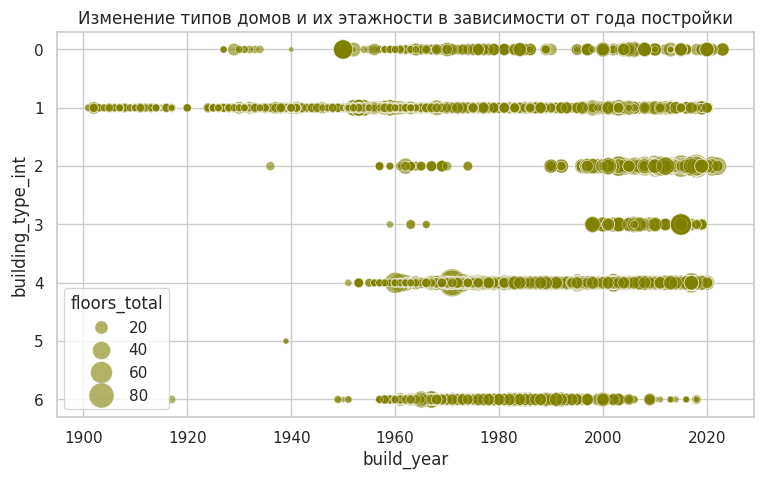

In [15]:
ax = sns.scatterplot(
    data,
    x="build_year",
    y="building_type_int",
    size="floors_total",
    alpha=0.6,
    sizes=(15, 400),
    color="olive",
).set_title("Изменение типов домов и их этажности в зависимости от года постройки")

plt.savefig(os.path.join(ARTIF_EDA, "fig2_3_4"))
plt.show()

### 2.4 Анализ целевой переменной

#### 2.4.1 Взглянем на статические показатели распределения целевого признака в цифровом и графическом виде

In [16]:
prices = data.target / 1000000
prices.describe()

count    100935.000000
mean         13.995753
std          46.933943
min           0.000011
25%           8.700000
50%          11.350000
75%          15.300000
max        9799.999488
Name: target, dtype: float64

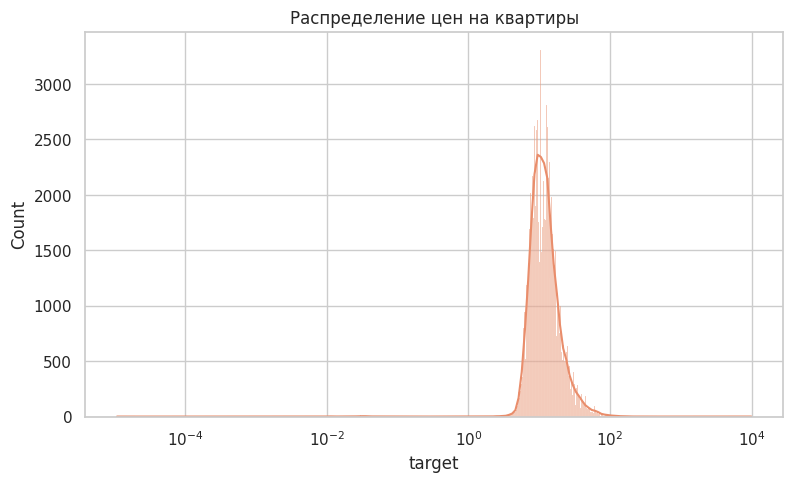

In [17]:
sns.histplot(prices, log_scale=True, kde=True).set_title(
    "Распределение цен на квартиры"
)
plt.savefig(os.path.join(ARTIF_EDA, "fig2_4_1_1"))
plt.show();

Судя по распределению целевого признака, мы имеем некоторое количество выбросов с аномально большими или маленькими ценами на квартиры. Если слишком большие цены могут быть просто элитным жильем, то маленькие являются ошибкой в данных (возможно кто-то запутался в нулях). <br>
Удалим выбросы вручную. За нижнюю границу возьмем конкретное число исходя из распределения цен, а верхнюю границу возьмем по межквартильному размаху с коэффициентом `3`.

In [ ]:
lower = 1e6
threshold = 3

upper = data.target.quantile(0.75) * threshold

data = data.query(f"target > {lower} & target < {upper}")

data.shape, upper

((99357, 15), 45900000.0)

Посмотрим как теперь выглядит распределение цен на квартиры.

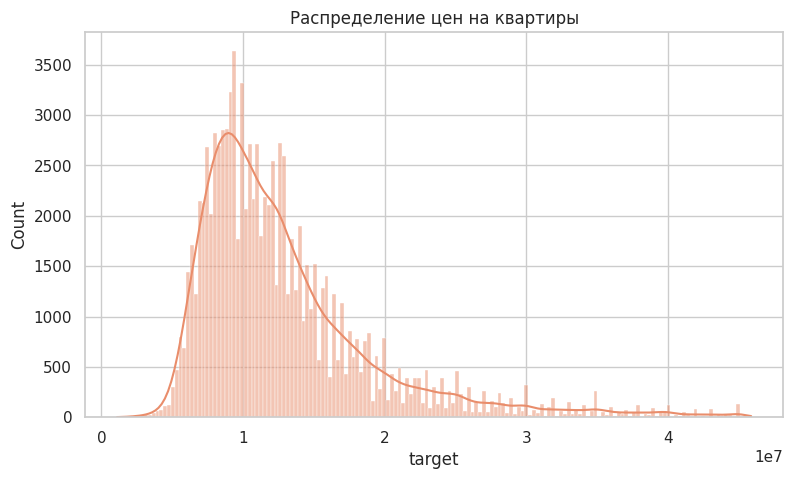

In [19]:
sns.histplot(data.target, kde=True).set_title("Распределение цен на квартиры")
plt.savefig(os.path.join(ARTIF_EDA, "fig2_4_1_2"))
plt.show();

### 2.5 Анализ целевой переменной в зависимости от различных признаков

#### 2.5.1 <a id='график2'></a> Посмотрим как меняется средняя и медианная цена в зависимости от года постройки дома

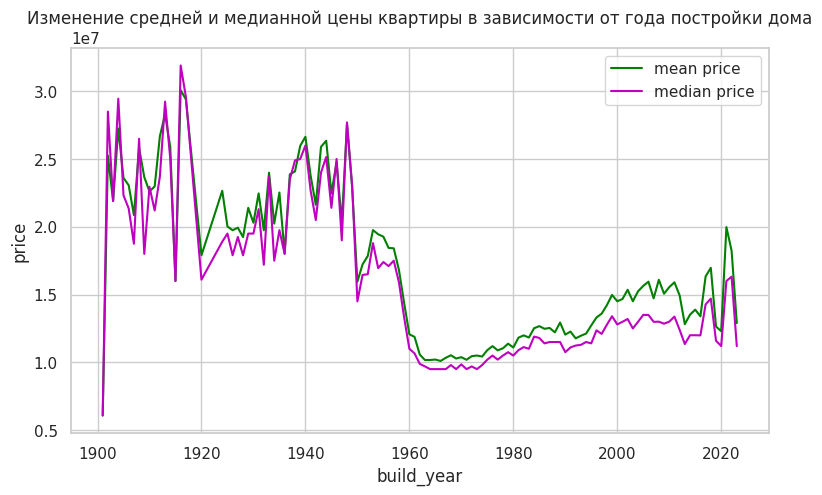

In [20]:
df = data.groupby("build_year").agg({"target": ["mean", "median"]}).reset_index()
ax = sns.lineplot(df, x="build_year", y=("target", "mean"), label="mean price", c="g")
sns.lineplot(
    df, x="build_year", y=("target", "median"), label="median price", ax=ax, c="m"
)
ax.legend()
ax.set_ylabel("price")
ax.set_title(
    "Изменение средней и медианной цены квартиры в зависимости от года постройки дома"
)
plt.savefig(os.path.join(ARTIF_EDA, "fig2_5_1"))
plt.show()

#### 2.5.2 <a id='график3'></a> Изучим распределение цен на квартиры в зависимости от типа дома в котором эта квартира находится.

2024-08-15 10:24:05,139 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-15 10:24:05,260 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-15 10:24:05,288 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


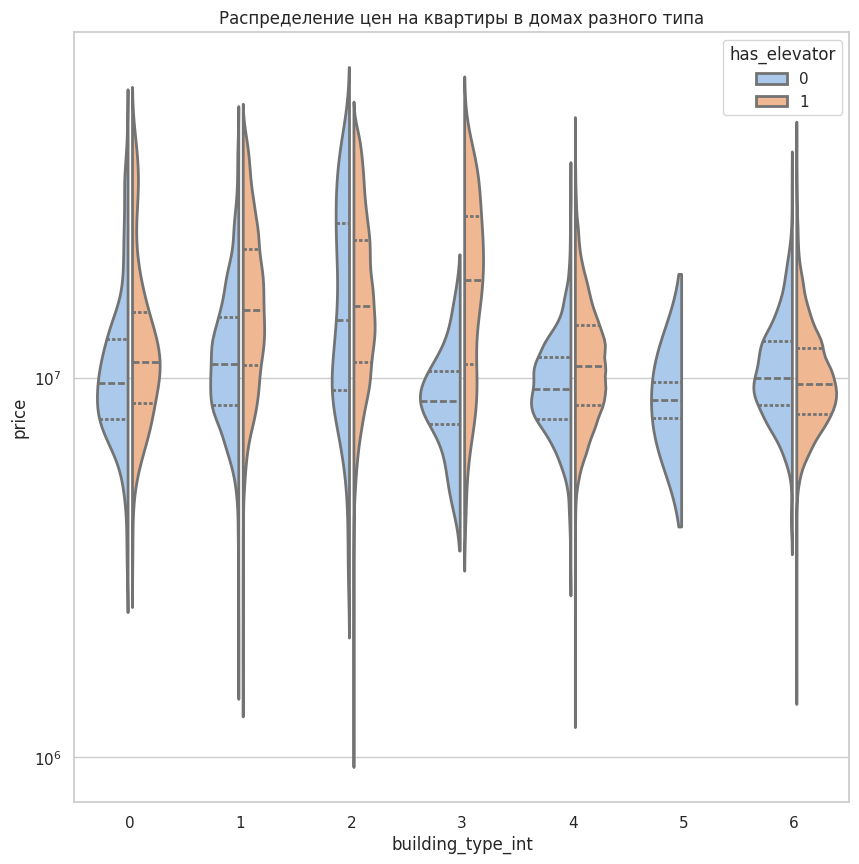

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = sns.violinplot(
    data,
    x="building_type_int",
    y="target",
    hue="has_elevator",
    split=True,
    gap=0.1,
    inner="quart",
    log_scale=True,
    palette="pastel",
    linewidth=2,
)
ax.set_ylabel("price")
ax.set_title("Распределение цен на квартиры в домах разного типа")
plt.savefig(os.path.join(ARTIF_EDA, "fig2_5_2"))
plt.show()

#### 2.5.3 <a id='4'></a> Изучим влияние общей площади квартиры и высоты потолков на ее цену.

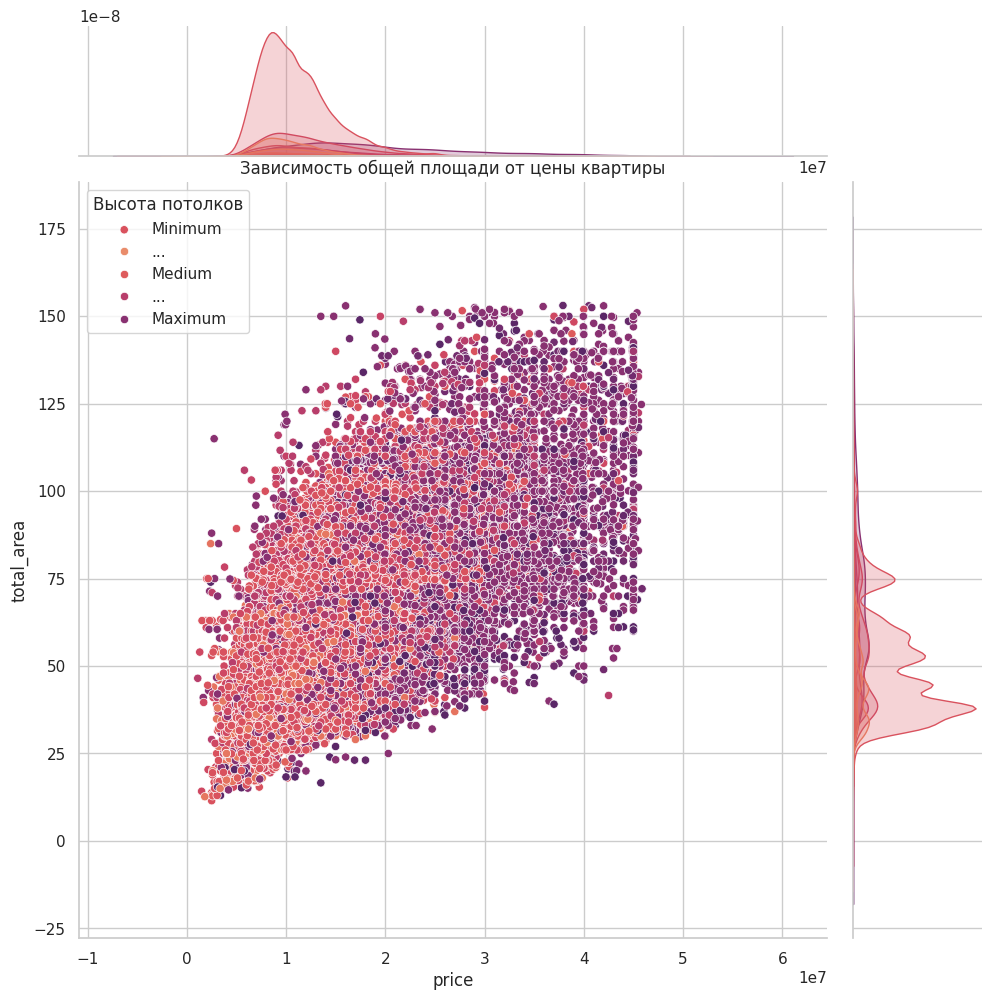

In [22]:
g = sns.jointplot(
    data,
    x="target",
    y="total_area",
    hue="ceiling_height",
    palette="flare",
    height=10,
)
g.ax_joint.set_xlabel("price")

g.ax_joint.legend(
    title="Высота потолков",
    loc="upper left",
    labels=["Minimum", "...", "Medium", "...", "Maximum"],
)
g.ax_joint.set_title("Зависимость общей площади от цены квартиры")
plt.savefig(os.path.join(ARTIF_EDA, "fig2_5_3"))
plt.show()

### 2.6 Выводы после EDA

Мы имеем таблицу на 99357 строк и 14 признаков, включая целевой признак. Глядя на данные, можно заметить следующее:

- Большинство данных имеет числовой формат `int` или `float`. При этом мы имеем столбец `building_type_int` которой по своей сути является <br> категориальным признаком. Есть 2 столбца (`has_elevator` и `is_apartment`) с числовыми бинарными признаками, не требующими обработки.
- Имеется некоторая корреляция между признаками. Признаки `total_area`, `kitchen_area`, `living_area` и `rooms` ожидаемо имеют высокую корреляцию <br> между собой, так как являются общими составляющими площади квартиры. Также заметно их влияние на целевую переменную.
- Числовые столбцы `floor`, `rooms`, `build_year` и `floors_total`, несмотря на длинный хвост в распределении данных, похожи на реальные редкие <br> параметры некоторых квартир.
- столбцы `total_area` и `living_area` имеют довольно сильную корреляцию друг с другом, что естественно для жилых квартир. Но при увеличении <br> `total_area`, площадь кухни увеличивается до определенных значений и держится в постоянном диапазоне.
- График 2.3.4 показывает, что с годами продолжается строительство некоторых типов домов, хотя появляются и новые типы. Также общая этажность <br>  домов имеет тенденцию увеличиваться с течением времени.
- Признаки `latitude` и `longitude` показывают географически координаты объекта недвижимости, они имеют нормальное распределение и, по небольшому диапазону разброса, можно сказать, что в данных речь идет о неком отдельном городе. 
- Целевой признак - стоимость квартиры - имеет нормальное распределение, но при этом очень длинные хвосты с выбросами в обе стороны, от которых мы успешно избавились.
- Глядя на график 2.5.1 заметно, что чем ближе год постройки дома к нашему времени тем меньше средняя и медианная стоимости квартир в нём, <br>
при это видно, что в более новых домах увеличивается разница между средней и медианной стоимость квартир. Это может говорить о том, что в <br> 
современных домах начинает увеличиваться количество дешевых квартир по сравнению с дорогими. 
- Если посмотреть распределение (график 2.5.2) цен квартир от типа дома - то видно, что в среднем тип дома не особо влияет на цену квартиры, <br> однако отдельные типы домов имеют бОльший разброс в ценах. Ну и чаще всего при одном типе дома наличие лифта будет поводом увеличить цену квартиры.
- Бинарные признаки `is_apartment` и `has_elevator` имеют очень сильный дисбалланс классов и могут оказаться мало информативны для последующей модели. 
- Главный признак имеющий корреляцию с целевым total_area действительно (график 2.5.3) увеличивает стоимость квартиры, но с широким диапазоном <br> 
вариативности. Это доказывает, что по значению одного этого признака нельзя судить о цене квартиры. Также бОльшую стоимость имеют квартиры с <br>
более высокими значениями высоты потолка при той же площади квартиры.

На основании полученных наблюдений можно предпринять ряд действий в последующей работе:
* Из признаков имеющих большую корреляцию друг с другом (`total_area`, `living_area` и `rooms`) оставим только `total_area`, остальные удалим. Признак `kitchen_area` оставим, как несущий собственную информацию, которую не получить из других.
* Бинарные неинформативные признаки `is_apartment` и `has_elevator` на данном этапе оставим и, далее посмотрим, как на них будут реагировать алгоритмы по отбору признаков.
* Признаки `latitude` и `longitude` преобразуем в единый признак "расстояние до центра".
* Таким образом, информативных признаков об объектах мы имеет не очень много, попробуем компенсировать это на стадии создания новых признаков.
* Так как мы планируем использовать модели на основе решающих деревьев, мы не будем масштабировать признаки, а единственные категориальный признак преобразуем с помощью one_hot кодирования.

In [60]:
concls = """
Мы имеем таблицу на 99357 строк и 14 признаков, включая целевой признак. Глядя на данные, можно заметить следующее:

- Большинство данных имеет числовой формат `int` или `float`. При этом мы имеем столбец `building_type_int` которой по своей сути является <br> категориальным признаком. Есть 2 столбца (`has_elevator` и `is_apartment`) с числовыми бинарными признаками, не требующими обработки.
- Имеется некоторая корреляция между признаками. Признаки `total_area`, `kitchen_area`, `living_area` и `rooms` ожидаемо имеют высокую корреляцию <br> между собой, так как являются общими составляющими площади квартиры. Также заметно их влияние на целевую переменную.
- Числовые столбцы `floor`, `rooms`, `build_year` и `floors_total`, несмотря на длинный хвост в распределении данных, похожи на реальные редкие <br> параметры некоторых квартир.
- столбцы `total_area` и `living_area` имеют довольно сильную корреляцию друг с другом, что естественно для жилых квартир. Но при увеличении <br> `total_area`, площадь кухни увеличивается до определенных значений и держится в постоянном диапазоне.
- График 2.3.4 показывает, что с годами продолжается строительство некоторых типов домов, хотя появляются и новые типы. Также общая этажность <br>  домов имеет тенденцию увеличиваться с течением времени.
- Признаки `latitude` и `longitude` показывают географически координаты объекта недвижимости, они имеют нормальное распределение и, по небольшому диапазону разброса, можно сказать, что в данных речь идет о неком отдельном городе. 
- Целевой признак - стоимость квартиры - имеет нормальное распределение, но при этом очень длинные хвосты с выбросами в обе стороны, от которых мы успешно избавились.
- Глядя на график 2.5.1 заметно, что чем ближе год постройки дома к нашему времени тем меньше средняя и медианная стоимости квартир в нём, <br>
при это видно, что в более новых домах увеличивается разница между средней и медианной стоимость квартир. Это может говорить о том, что в <br> 
современных домах начинает увеличиваться количество дешевых квартир по сравнению с дорогими. 
- Если посмотреть распределение (график 2.5.2) цен квартир от типа дома - то видно, что в среднем тип дома не особо влияет на цену квартиры, <br> однако отдельные типы домов имеют бОльший разброс в ценах. Ну и чаще всего при одном типе дома наличие лифта будет поводом увеличить цену квартиры.
- Бинарные признаки `is_apartment` и `has_elevator` имеют очень сильный дисбалланс классов и могут оказаться мало информативны для последующей модели. 
- Главный признак имеющий корреляцию с целевым total_area действительно (график 2.5.3) увеличивает стоимость квартиры, но с широким диапазоном <br> 
вариативности. Это доказывает, что по значению одного этого признака нельзя судить о цене квартиры. Также бОльшую стоимость имеют квартиры с <br>
более высокими значениями высоты потолка при той же площади квартиры.

На основании полученных наблюдений можно предпринять ряд действий в последующей работе:
* Из признаков имеющих большую корреляцию друг с другом (`total_area`, `living_area` и `rooms`) оставим только `total_area`, остальные удалим. Признак `kitchen_area` оставим, как несущий собственную информацию, которую не получить из других.
* Бинарные неинформативные признаки `is_apartment` и `has_elevator` на данном этапе оставим и, далее посмотрим, как на них будут реагировать алгоритмы по отбору признаков.
* Признаки `latitude` и `longitude` преобразуем в единый признак "расстояние до центра".
* Таким образом, информативных признаков об объектах мы имеет не очень много, попробуем компенсировать это на стадии создания новых признаков.
* Так как мы планируем использовать модели на основе решающих деревьев, мы не будем масштабировать признаки, а единственные категориальный признак преобразуем с помощью one_hot кодирования.
"""

In [61]:
with open(os.path.join(ARTIF_EDA, "conclusions.md"), "w", encoding="utf-8") as ff:
    ff.write(concls)

### 2.7 логирование артефактов в MLflow

In [12]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [63]:
EXPERIMENT_NAME = "project_sprint_2_1"
RUN_NAME = "EDA"


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id, RUN_NAME)

    mlflow.log_artifact(ARTIF_EDA, "eda")
    mlflow.log_artifact("project_sprint_2_with_notes.ipynb", "eda")

8babcbecbd9d4b75b2607cdcbb72eb0b EDA


## Этап 3: Генерация Признаков и Обучение Новой Версии Модели
На этом этапе приступим к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используем наше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуемся библиотекой для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.

После генерации новых признаков обучим новую версию нашей модели, используя эти признаки. Далее залогируем все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

### 3.0 дополнительная предобработка по результатам EDA

Для начала удалим признаки, имеющие сильную корреляцию друг с другом.

In [24]:
data = data.drop(["living_area", "rooms"], axis=1)

Теперь заменим сложноинтерпретируемые признаки `latitude` и `longitude`.
Преобразуем оба признака в один признак - "расстояние до центра", в качестве центра используем средние значения обоих признаков.
Так как георафически мы имеем малый разброс по координатам, пренебрежём изгибом земной поверхности и вычислим евклидово расстояние между каждой координатой и центром.

In [25]:
center = np.array((data.latitude.mean(), data.longitude.mean()))
coordinates = list(zip(data.latitude, data.longitude))

data["distance_to_center"] = [
    np.linalg.norm(center - place).round(3) for place in coordinates
]

data = data.drop(["latitude", "longitude"], axis=1)

Посмотрим на созданный признак.

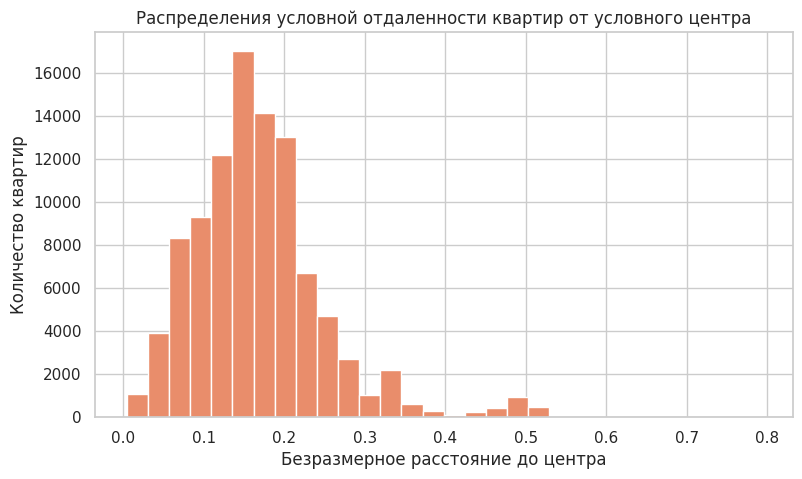

In [26]:
data["distance_to_center"].hist(bins=30)
plt.xlabel("Безразмерное расстояние до центра")
plt.ylabel("Количество квартир")
plt.title("Распределения условной отдаленности квартир от условного центра");

### 3.1 ручная генерация признаков

Имея небольшое количество признаков , выберем вручную признаки для преобразования через sclearn.

Еще раз посмотрим на данные и разделим их на часть для обучения и тестирования моделей.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99357 entries, 0 to 100934
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   floor               99357 non-null  int64   
 1   is_apartment        99357 non-null  int64   
 2   kitchen_area        99357 non-null  float64 
 3   total_area          99357 non-null  float64 
 4   target              99357 non-null  int64   
 5   build_year          99357 non-null  int64   
 6   building_type_int   99357 non-null  category
 7   ceiling_height      99357 non-null  float64 
 8   flats_count         99357 non-null  int64   
 9   floors_total        99357 non-null  int64   
 10  has_elevator        99357 non-null  int64   
 11  distance_to_center  99357 non-null  float64 
dtypes: category(1), float64(4), int64(7)
memory usage: 9.2 MB


In [18]:
X_train, X_test, y_train, y_test = split(
    data.drop(["target"], axis=1), data["target"], test_size=0.15
)


for df in [X_train, X_test, y_train, y_test]:
    print(f"размер выборки {df.shape}")

размер выборки (84453, 11)
размер выборки (14904, 11)
размер выборки (84453,)
размер выборки (14904,)


Определим признаки, которые мы преобразуем в дальнейшем. Так как предполагаемая модель - это `CatBoostRegressor`, то есть модель на основе деревьев - мы не будем заниматься предобработкой численных данных. 

Единственный категориальный столбец обработаем с помощью `OneHotEncoder`.<br>
Часть новых столбцов создадим из числовых признаков.<br>
Для создания используем `KBinsDiscretizer` и `PolynomialFeatures`.<br>
В `PolynomialFeatures` подадим все численные признаки, кроме бинарных.<br>
В `KBinsDiscretizer` подадим те признаки, которые могут быть разбиты на группы и, при этом не потерять своей смысловой нагрузки. 

In [19]:
cat_col = ["building_type_int"]
num_col = (
    data.select_dtypes(include=["int", "float"])
    .drop(["has_elevator", "is_apartment", "target"], axis=1)
    .columns
)

kbins_cols = ["kitchen_area", "total_area", "distance_to_center", "build_year"]
polinom_cols = num_col

### 3.2 оборачивание всех преобразований в объекты sklearn

In [20]:
sparse_output = False
categories = "auto"
handle_unknown = "ignore"
drop = "first"
degree = (2, 3)
n_bins = 8
encode = "ordinal"
strategy = "kmeans"
subsample = None
interaction_only = False


encoder_oh = OneHotEncoder(
    sparse_output=sparse_output,
    categories=categories,
    handle_unknown=handle_unknown,
    drop=drop,
)

encoder_kbd = KBinsDiscretizer(
    n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample
)
encoder_pol = PolynomialFeatures(degree=degree, interaction_only=interaction_only)

categories_transformer = Pipeline(steps=[("encoder", encoder_oh)])

numeric_transformer = ColumnTransformer(
    transformers=[
        ("kbd", encoder_kbd, kbins_cols),
        ("pol", encoder_pol, polinom_cols),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoder_num", numeric_transformer, num_col),
        ("encoder_category", categories_transformer, cat_col),
    ],
    n_jobs=-1,
)

Запустим процесс предобработки и создание признаков и посмотрим на результаты.

In [22]:
encoded_features = preprocessor.fit_transform(X_train, y_train)

hand_transformed_df = pd.DataFrame(
    encoded_features, columns=preprocessor.get_feature_names_out()
)
print(hand_transformed_df.columns)
hand_transformed_df.head()

Index(['encoder_num__kbd__kitchen_area', 'encoder_num__kbd__total_area',
       'encoder_num__kbd__distance_to_center', 'encoder_num__kbd__build_year',
       'encoder_num__pol__1', 'encoder_num__pol__floor^2',
       'encoder_num__pol__floor kitchen_area',
       'encoder_num__pol__floor total_area',
       'encoder_num__pol__floor build_year',
       'encoder_num__pol__floor ceiling_height',
       ...
       'encoder_num__pol__floors_total^3',
       'encoder_num__pol__floors_total^2 distance_to_center',
       'encoder_num__pol__floors_total distance_to_center^2',
       'encoder_num__pol__distance_to_center^3',
       'encoder_category__building_type_int_1',
       'encoder_category__building_type_int_2',
       'encoder_category__building_type_int_3',
       'encoder_category__building_type_int_4',
       'encoder_category__building_type_int_5',
       'encoder_category__building_type_int_6'],
      dtype='object', length=167)


encoder_num__kbd__kitchen_area  encoder_num__kbd__total_area   
0                             1.0                           0.0  \
1                             3.0                           4.0   
2                             3.0                           3.0   
3                             3.0                           3.0   
4                             5.0                           2.0   

   encoder_num__kbd__distance_to_center  encoder_num__kbd__build_year   
0                                   1.0                           4.0  \
1                                   0.0                           2.0   
2                                   1.0                           4.0   
3                                   1.0                           5.0   
4                                   3.0                           7.0   

   encoder_num__pol__1  encoder_num__pol__floor^2   
0                  1.0                       25.0  \
1                  1.0                        9.0   
2                  1.0                       64.0   
3                  1.0                       49.0   
4                  1.0                      576.0   

   encoder_num__pol__floor kitchen_area  encoder_num__pol__floor total_area   
0                             30.000000                          160.000000  \
1                             30.000000                          235.500000   
2                             76.000000                          520.000000   
3                             70.000000                          420.000000   
4                            340.799995                         1303.199982   

   encoder_num__pol__floor build_year  encoder_num__pol__floor ceiling_height   
0                              9850.0                               13.200001  \
1                              5826.0                                9.600000   
2                             15792.0                               21.120001   
3                             13923.0                               18.480001   
4                             48240.0                               65.760000   

   ...  encoder_num__pol__floors_total^3   
0  ...                             729.0  \
1  ...                             512.0   
2  ...                            2744.0   
3  ...                            4913.0   
4  ...                           15625.0   

   encoder_num__pol__floors_total^2 distance_to_center   
0                                              9.963    \
1                                              0.896     
2                                             20.580     
3                                             38.148     
4                                            164.375     

   encoder_num__pol__floors_total distance_to_center^2   
0                                           0.136161    \
1                                           0.001568     
2                                           0.154350     
3                                           0.296208     
4                                           1.729225     

   encoder_num__pol__distance_to_center^3   
0                                0.001861  \
1                                0.000003   
2                                0.001158   
3                                0.002300   
4                                0.018191   

   encoder_category__building_type_int_1   
0                                    0.0  \
1                                    1.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   encoder_category__building_type_int_2   
0                                    0.0  \
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   encoder_category__building_type_int_3   
0                                    0.0  \
1                           

### 3.3 автоматическая генерация признаков

Для автоматического создания признаков будем использовать библиотеку `autofeat`

In [ ]:
transformations = ("exp", "log")

afc = AutoFeatRegressor(
    categorical_cols=None,
    feateng_cols=list(num_col),
    feateng_steps=2,
    max_gb=12,
    n_jobs=None,
    transformations=transformations,
    units=None,
    verbose=1,
)

auto_transformed_df = afc.fit_transform(X_train, y_train)

auto_transformed_df

Соеденим признаки полученные автоматически и с помощью библиотеки sklearn.

In [24]:
data_train = pd.concat([hand_transformed_df, auto_transformed_df], axis=1)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84453 entries, 0 to 84452
Columns: 208 entries, encoder_num__kbd__kitchen_area to floors_total*log(distance_to_center)
dtypes: float64(208)
memory usage: 134.0 MB


### 3.4 обучение новой версии модели

Для корректного обучения модели преобразуем тестовые данные

In [25]:
encode_test_features = preprocessor.transform(X_test)
hand_test_features = pd.DataFrame(
    encode_test_features, columns=preprocessor.get_feature_names_out()
)
auto_test_features = afc.transform(X_test)
data_test = pd.concat([hand_test_features, auto_test_features], axis=1)
data_test.info()

2024-08-15 07:30:38,209 INFO: [AutoFeat] Computing 30 new features.
2024-08-15 07:30:38,383 INFO: [AutoFeat]    30/   30 new features ...done.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14904 entries, 0 to 14903
Columns: 208 entries, encoder_num__kbd__kitchen_area to floors_total*log(distance_to_center)
dtypes: float64(208)
memory usage: 23.7 MB


Напишем универсальную функцию для обучения модели и проверке на тестовых данных

In [26]:
def refit(model_params, data_train, y_train, data_test, y_test):
    metrics = {}
    t0 = time.time()
    model = CatBoostRegressor(**model_params)
    model.fit(data_train, y_train)
    metrics["fit_time"] = time.time() - t0
    prediction = model.predict(data_test)

    metrics["test_mse"] = mean_squared_error(y_test, prediction)
    metrics["test_mae"] = mean_absolute_error(y_test, prediction)
    metrics["test_mape"] = mean_absolute_percentage_error(y_test, prediction)
    return metrics, model, prediction

Выберем параметры для модели и обучим ее на обновленных данных

In [ ]:
model_params = {
    "loss_function": "RMSE",
    "iterations": 300,
    "learning_rate": 0.05,
    "l2_leaf_reg": 0.6,
    "early_stopping_rounds": 15,
    "depth": 3,
    "random_seed": SEED,
    "verbose": 1,
}

metrics_new_fea, model, prediction = refit(
    model_params,
    data_train=data_train,
    y_train=y_train,
    data_test=data_test,
    y_test=y_test,
)
metrics_new_fea

Достанем из mlflow метрики базовой модели для сравнения.

In [28]:
client = MlflowClient()
run_id = "d831908157f043b4945723bf936727f3"

base_metrics = client.get_run(run_id).data.metrics

compare = pd.DataFrame(
    [base_metrics, metrics_new_fea], index=["base", "with_new_features"]
).drop(
    [
        "score_time",
        "test_neg_mean_squared_error",
        "test_neg_mean_absolute_percentage_error",
    ],
    axis=1,
)
compare.style.highlight_min(color="olive", axis=0).format("{:.4}")

Как видно, добавление дополнительных признаков к данным, значительно улучшило метрики `mse` и `mape`, при этом время затраченное на обучение незначительно увеличилось.

### 3.5 логирование артефактов в MLflow

Сохраним все полученные результаты

In [ ]:
RUN_NAME = "new_features"
REGISTRY_MODEL_NAME = "model_with_new_features"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(
    data_test[:10], prediction[:10], model.get_params()
)
input_example = data_test[:10]
metadata = {"model_type": "CatBoost"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_new_fea)
    mlflow.log_params(model.get_params())

    afc_info = mlflow.sklearn.log_model(afc, artifact_path="afc")

    preproc_info = mlflow.sklearn.log_model(
        preprocessor, artifact_path="ckl_preprocessor"
    )

    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "project_2_1")

## Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы применим различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, обучим новую версию вашей модели, уже без негативно влияющих на неё признаков. Затем залогируем результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.


### 4.1 Отбор признаков при помощи метода номер 1

На первом этапе отсеим часть признаков с помощью библиотеки `sklearn` и способа, используещего `feature_importances` обученной модели.

На этом этапе оставим около 30 признаков от наших данных

In [ ]:
%%time

reg = CatBoostRegressor(**model_params)

model_selector = SelectFromModel(
    reg,
    threshold=-np.inf,
    prefit=False,
    max_features=30,
)
model_selector.fit(data_train, y_train)
first_fea_select = model_selector.transform(data_train)

first_fea_select = pd.DataFrame(
    first_fea_select, columns=model_selector.get_feature_names_out()
)
first_fea_select

### 4.2 Отбор признаков при помощи метода Sequential Selection
#### 4.2.1 Отбор признаков при помощи метода номер 2(Sequential Forward Selection)

На этом этапе запустим механизм Sequential Forward Selection для отбора признаков из библиотеки `mlxtend`.

В этом отборе оставим только 10 наилучших признаков.

In [ ]:
%%time
model_params.update({"verbose": 0})

reg = CatBoostRegressor(**model_params)

sfs = SFS(
    reg,
    k_features=10,
    forward=True,
    floating=False,
    scoring="neg_mean_absolute_percentage_error",
    cv=4,
    n_jobs=-1,
    verbose=1,
    clone_estimator=False,
)

sfs = sfs.fit(first_fea_select, y_train)

sfs_features = sfs.k_feature_names_

print("\nSequential Forward Selection (k=10)")
print("CV Score:")
print(sfs.k_score_)
print(sfs_features)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.5min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:  4.7min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  4.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.7min finished
Features: 4/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  4.7min finished
Features: 5/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.7min finished
Features: 6/10[Parallel(n_jobs=-1)]: Using backe


Sequential Forward Selection (k=10)
CV Score:
-0.19085687075200158
('encoder_num__pol__build_year^2', 'encoder_num__pol__kitchen_area^2 ceiling_height', 'encoder_num__pol__total_area^2 floors_total', 'encoder_num__pol__build_year^2 distance_to_center', 'encoder_num__pol__build_year ceiling_height^2', 'encoder_num__pol__build_year ceiling_height distance_to_center', 'total_area', 'building_type_int', 'total_area*log(distance_to_center)', 'exp(ceiling_height)*log(floors_total)')
CPU times: user 7.93 s, sys: 2.56 s, total: 10.5 s
Wall time: 47min 20s


Посмотрим и сохраним отобранные признаки и метрики в локальное хранилище для последующего логирования.

In [32]:
ASSETS = "artif_select"
if not os.path.exists(ASSETS):
    os.makedirs(ASSETS)

In [33]:
sfs_metric_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

sfs_metric_df.to_csv(f"{ASSETS}/sfs.csv")

In [34]:
sfs_metric_df.head(3)

feature_idx                                          cv_scores avg_score   
1         (23,)  [-0.20934955971695568, -0.21020569890378535, -... -0.210109  \
2      (23, 25)  [-0.19858468763762155, -0.19814850727084993, -...  -0.19844   
3  (13, 23, 25)  [-0.1930608150018961, -0.19285505977340087, -0... -0.193163   

                                       feature_names  ci_bound   std_dev   
1              (total_area*log(distance_to_center),)  0.000818   0.00051  \
2  (total_area*log(distance_to_center), exp(ceili...  0.000823  0.000513   
3  (encoder_num__pol__build_year^2 distance_to_ce...  0.000899  0.000561   

    std_err  
1  0.000295  
2  0.000296  
3  0.000324

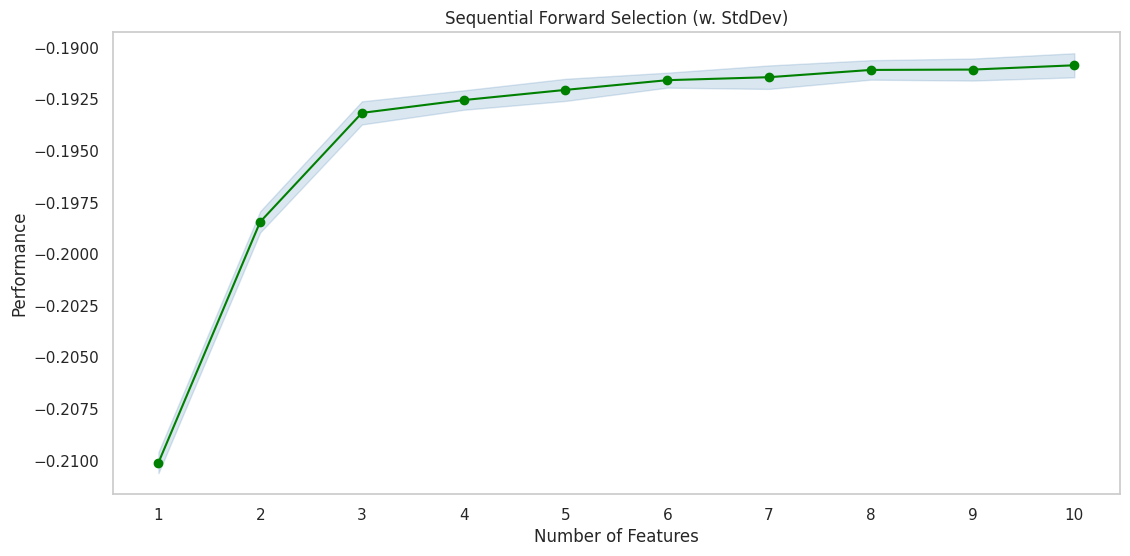

In [35]:
fig = plot_sfs(sfs.get_metric_dict(), kind="std_dev", color="green")

plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()

plt.savefig(f"{ASSETS}/sfs.png")
plt.show()

#### 4.2.2 Отбор признаков при помощи метода номер 3 (Sequential Backward Selection)


Далее запустим механизм Sequential Backward Selection из той же `mlxtend` для отбора признаков .

В этом отборе также оставим 10 наилучших признаков по расчетам алгоритма.

In [ ]:
%%time
reg = CatBoostRegressor(**model_params)
sbs = SFS(
    reg,
    k_features=10,
    forward=False,
    floating=False,
    scoring="neg_mean_absolute_percentage_error",
    cv=4,
    n_jobs=-1,
    verbose=1,
    clone_estimator=False,
)

sbs = sbs.fit(first_fea_select, y_train)
sbs_features = sbs.k_feature_names_

print("\nSequential Backward Selection")
print("CV Score:")
print(sbs.k_score_)
print(sbs_features)

Посмотрим и сохраним отобранные признаки и метрики в локальное хранилище для последующего логирования.

In [33]:
sbs_metric_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

sbs_metric_df.to_csv(f"{ASSETS}/sbs.csv")

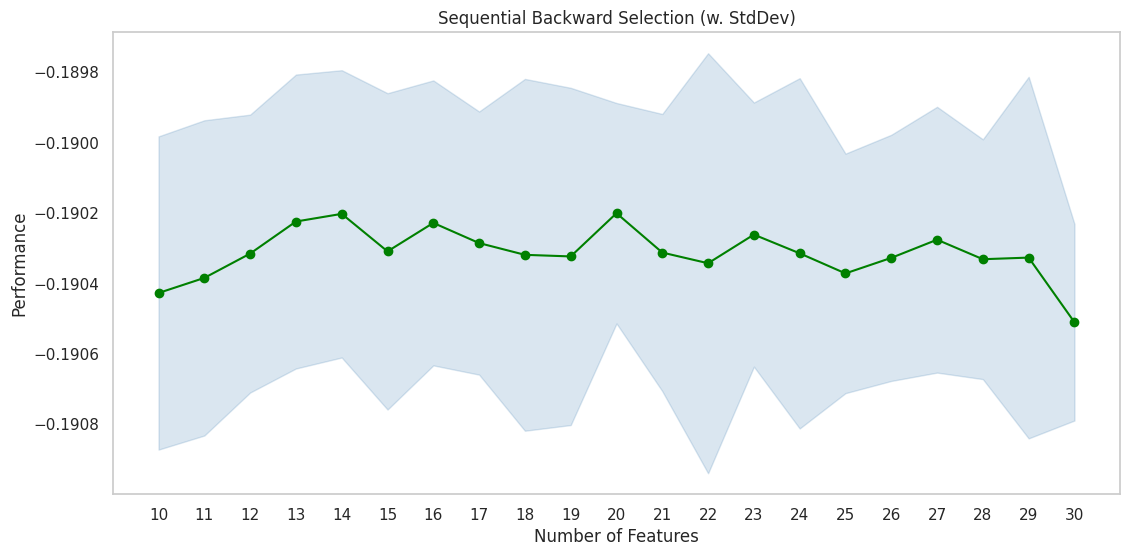

In [32]:
fig = plot_sfs(sbs.get_metric_dict(), kind="std_dev", color="green")

plt.title("Sequential Backward Selection (w. StdDev)")
plt.grid()

plt.savefig(f"{ASSETS}/sbs.png")
plt.show()

### 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

Посмотрим какое влияние на модель оказывали признаки среди которых она выбирала лучшие

In [43]:
# with open(f"{ASSETS}/sfs_sbs_fea.json", "r") as fd:
#     sbs_features = json.load(fd)

# sbs_features = sbs_features["sbs_features"]

['encoder_num__pol__build_year ceiling_height',
 'encoder_num__pol__total_area^2 floors_total',
 'encoder_num__pol__total_area build_year ceiling_height',
 'encoder_num__pol__build_year^2 ceiling_height',
 'encoder_num__pol__build_year^2 distance_to_center',
 'encoder_num__pol__ceiling_height^2 distance_to_center',
 'building_type_int',
 'log(distance_to_center)*log(floor)',
 'total_area*log(distance_to_center)',
 'floors_total*log(distance_to_center)']

In [44]:
print(f"Список признаков по методу sfs :{sfs_features}")
print(f"\n")
print(f"Список признаков по методу sbs :{sbs_features}")

Список признаков по методу sfs :('encoder_num__pol__build_year^2', 'encoder_num__pol__kitchen_area^2 ceiling_height', 'encoder_num__pol__total_area^2 floors_total', 'encoder_num__pol__build_year^2 distance_to_center', 'encoder_num__pol__build_year ceiling_height^2', 'encoder_num__pol__build_year ceiling_height distance_to_center', 'total_area', 'building_type_int', 'total_area*log(distance_to_center)', 'exp(ceiling_height)*log(floors_total)')


Список признаков по методу sbs :['encoder_num__pol__build_year ceiling_height', 'encoder_num__pol__total_area^2 floors_total', 'encoder_num__pol__total_area build_year ceiling_height', 'encoder_num__pol__build_year^2 ceiling_height', 'encoder_num__pol__build_year^2 distance_to_center', 'encoder_num__pol__ceiling_height^2 distance_to_center', 'building_type_int', 'log(distance_to_center)*log(floor)', 'total_area*log(distance_to_center)', 'floors_total*log(distance_to_center)']


In [45]:
with open(f"{ASSETS}/sfs_sbs_fea.json", "w") as fd:
    json.dump({"sfs_features": sfs_features, "sbs_features": sbs_features}, fd)

Для финального этапа оставим те признаки, которые отобрали оба алгоритма sfs и sbs

In [46]:
union_features = list(set(sfs_features) | set(sbs_features))
union_features

['encoder_num__pol__build_year ceiling_height^2',
 'encoder_num__pol__build_year^2',
 'encoder_num__pol__build_year ceiling_height',
 'floors_total*log(distance_to_center)',
 'encoder_num__pol__build_year^2 ceiling_height',
 'encoder_num__pol__total_area^2 floors_total',
 'encoder_num__pol__ceiling_height^2 distance_to_center',
 'total_area',
 'encoder_num__pol__total_area build_year ceiling_height',
 'encoder_num__pol__build_year^2 distance_to_center',
 'log(distance_to_center)*log(floor)',
 'exp(ceiling_height)*log(floors_total)',
 'encoder_num__pol__build_year ceiling_height distance_to_center',
 'total_area*log(distance_to_center)',
 'encoder_num__pol__kitchen_area^2 ceiling_height',
 'building_type_int']

### 4.4 Обучение новой версии модели

Обучим модель на отобранных признаках

In [47]:
cleen_X_train = data_train[union_features]
cleen_X_test = data_test[union_features]

metrics_selected, model, prediction = refit(
    model_params,
    data_train=cleen_X_train,
    y_train=y_train,
    data_test=cleen_X_test,
    y_test=y_test,
)
metrics_selected

{'fit_time': 7.586841821670532,
 'test_mse': 10547522322872.328,
 'test_mae': 2339058.1448504883,
 'test_mape': 0.19022001591788198}

In [49]:
compare_plus = pd.DataFrame(metrics_selected, index=["after_selection"])

compare = pd.concat([compare, compare_plus], axis=0)

compare.style.highlight_min(color="olive", axis=0).format("{:.4}")

По результатам отбора признаков - видно, что отбор признаков улучшил метрики очень незначительно, при этом время обучения снизилось втрое. Таким образом снизив количество признаков с 208 до 16 мы сохранили метрики качества и улучшили время обучения модели.

 Также в оставшихся 16ти признаках - 14 - это созданные нами признаки на этапе генерации, и всего 2 признака, сохранившиеся изначально. Хочется отметить, что признаки `is_apartment` и `has_elevator`, изначально вызывавшие сомнения, не попали в финальный список признаков

### 4.5 Логирование всех артефактов в MLflow

In [ ]:
EXPERIMENT_NAME = "project_sprint_2_1"
RUN_NAME = "selection_features"
REGISTRY_MODEL_NAME = "selected_features_model"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(
    cleen_X_train[:10], prediction[:10], model.get_params()
)
input_example = cleen_X_test[:10]
metadata = {"model_type": "CatBoost"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_selected)

    sel_info = mlflow.sklearn.log_model(model_selector, artifact_path="sk_selector")

    mlflow.log_artifact(ASSETS, "sfs_sbs")
    mlflow.log_params(model.get_params())

    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "project_2_1")

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального шага — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где наша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Мы будем подобирать гиперпараметры двумя различными методами (с использованием Random Search и Bayesian Optimization), чтобы мы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя наши новые признаки.

Оба варианта подбора параметров будем осуществлять при помощи библиотеки `optuna`.

Для начал напишем `trial` который подойдет к обоим вариантам

In [52]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 2, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.3, 5),
        "random_strength": trial.suggest_float("random_strength", 0.1, 5),
        "iterations": trial.suggest_int("iterations", 50, 1000),
        "loss_function": "RMSE",
        "task_type": "CPU",
        "random_seed": SEED,
        "early_stopping_rounds": 15,
        "verbose": False,
    }

    model = CatBoostRegressor(**param)

    skf = StratifiedKFold(n_splits=4)

    mse_full = []
    for i, (train_index, val_index) in enumerate(skf.split(cleen_X_train, y_train)):
        train_x = cleen_X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = cleen_X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]

        model.fit(train_x, train_y)
        prediction = model.predict(val_x)

        mse = mean_squared_error(val_y, prediction)

        mse_full.append(mse)

    mse_full = np.mean(mse_full)

    return mse_full

### 5.1 Подбор гиперпарметров при помощи метода RandomSearch

В этом способе воспользуемся методом `RandomSearch`, но с помощью `optuna`. Измерим качество на обучении и затраченное время.

In [ ]:
EXPERIMENT_NAME = "project_sprint_2_1"
RUN_NAME = "params_search"

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "project__2_v3"

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="RMSE",
    create_experiment=False,
    mlflow_kwargs={
        "experiment_id": experiment_id,
        "tags": {MLFLOW_PARENT_RUN_ID: run_id},
        "nested": True,
    },
)


SAMPLER = RandomSampler(seed=SEED)
study_rs = optuna.create_study(
    sampler=SAMPLER, direction="minimize", study_name=STUDY_NAME, storage=STUDY_DB_NAME
)


study_rs.optimize(
    objective,
    n_trials=30,
    show_progress_bar=True,
    callbacks=[mlflc],
)

best_params_rs = study_rs.best_params
train_score_rs = study_rs.best_value

print(f"Best params for RandomSearch {best_params_rs}")
print("\n")
print(f"Best score for train RandomSearch {train_score_rs}")

### 5.2 Подбор гиперпарметров при помощи метода TPE

Для второго способа был выбран байесовский подход к выбору гиперпараметров с помощью семплера TPESampler

In [ ]:
STUDY_NAME = "project__2_v3_1"

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="RMSE",
    create_experiment=False,
    mlflow_kwargs={
        "experiment_id": experiment_id,
        "tags": {MLFLOW_PARENT_RUN_ID: run_id},
        "nested": True,
    },
)


SAMPLER = TPESampler(seed=SEED)
study_tpe = optuna.create_study(
    sampler=SAMPLER, direction="minimize", study_name=STUDY_NAME, storage=STUDY_DB_NAME
)


study_tpe.optimize(
    objective,
    n_trials=30,
    show_progress_bar=True,
    callbacks=[mlflc],
)

best_params_tpe = study_tpe.best_params
train_score_tpe = study_tpe.best_value

print(f"Best params for TPE {best_params_tpe}")

print(f"Best score for train TPE {train_score_tpe}")

In [55]:
ASSETS_P = "artif_params_search"
if not os.path.exists(ASSETS_P):
    os.makedirs(ASSETS_P)

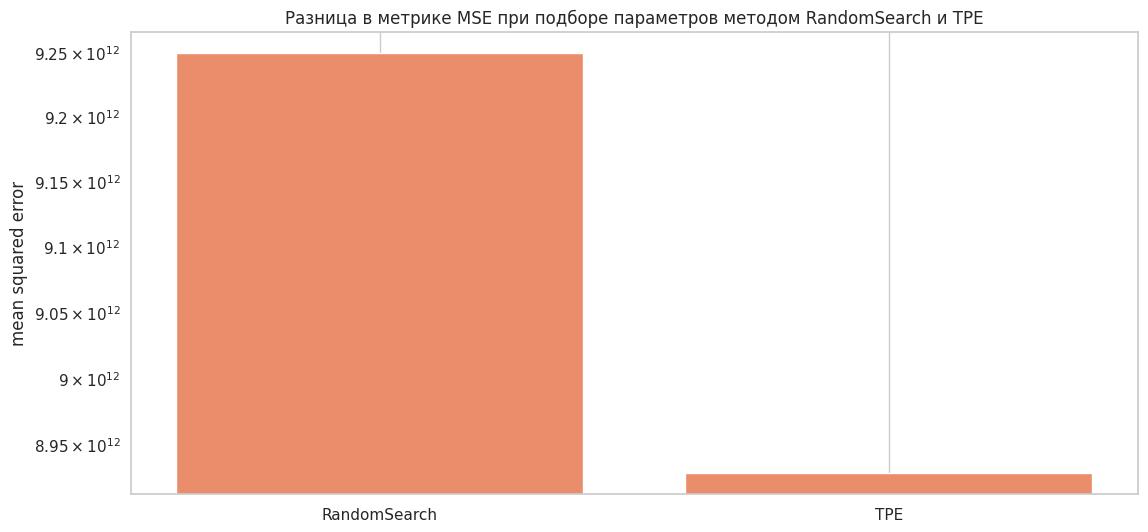

In [56]:
plt.bar(
    ["RandomSearch", "TPE"],
    [train_score_rs, train_score_tpe],
)
plt.yscale("log")
plt.title("Разница в метрике MSE при подборе параметров методом RandomSearch и TPE")
plt.ylabel("mean squared error")
plt.savefig(f"{ASSETS_P}/mse_search_params.png");

### 5.3 Формирование списка гиперпараметров для новой модели

Посмотрим на то, какие алгоритмы предпочитали какие параметры для оптимальной оценки модели.

In [57]:
print("\033[1m" + "Parameter relationships RandomSearch:")
fig = optuna.visualization.plot_parallel_coordinate(
    study_rs, params=["depth", "learning_rate", "l2_leaf_reg", "random_strength"]
)
fig.show()

print("\033[1m" + "Parameter relationships TPE:")
fig = optuna.visualization.plot_parallel_coordinate(
    study_tpe, params=["depth", "learning_rate", "l2_leaf_reg", "random_strength"]
)
fig.show()

Parameter relationships RandomSearch:


Parameter relationships TPE:


In [58]:
print("\033[1m" + "Parameter importance RandomSearch:")
fig = optuna.visualization.plot_param_importances(study_rs)

fig.show()

print("\033[1m" + "Parameter importance TPE:")
fig = optuna.visualization.plot_param_importances(study_tpe)

fig.show()

Parameter importance RandomSearch:


Parameter importance TPE:


По графикам заметно, что алгоритмы выбрали разные "значимые" параметры. Самым значимым параметром для TPE стало `learning_rate`, а для `RandomSearch`  стал параметр `l2_leaf_reg`. По остальным параметрам предпочтения тоже разошлись.

При этом алгоритм TPE показывает более "кучные" результаты, дающие лучшие оценки.

За финальные параметры возьмем набор, подобранный с помощь байесовской оптимизиции.

### 5.4 Обучение финальной версии модели

In [59]:
model_params.update(best_params_tpe)

metrics_final, model_final, prediction = refit(
    model_params,
    data_train=cleen_X_train,
    y_train=y_train,
    data_test=cleen_X_test,
    y_test=y_test,
)
metrics_final

{'fit_time': 17.02854347229004,
 'test_mse': 8787217282652.208,
 'test_mae': 2162100.052529805,
 'test_mape': 0.17776807133201583}

### 5.5 Логирование артефактов в MLflow

In [60]:
EXPERIMENT_NAME = "project_sprint_2_1"
RUN_NAME = "search_params_models"
REGISTRY_MODEL_NAME = "final_model"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(
    cleen_X_train[:10], prediction[:10], model.get_params()
)
input_example = cleen_X_test[:10]
metadata = {"model_type": "CatBoost"}

try:
    experiment_id
except NameError:
    experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    print(run_id)
    mlflow.log_metrics(metrics_final)

    mlflow.log_artifact(ASSETS_P, "optuna_graphs")
    mlflow.log_artifact("local.study.db", "optuna_db")
    mlflow.log_params(model.get_params())

    model_info = mlflow.catboost.log_model(
        cb_model=model_final,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        pip_requirements=pip_requirements,
        input_example=input_example,
        metadata=metadata,
        await_registration_for=60,
    )

client = MlflowClient()
client.set_registered_model_tag(REGISTRY_MODEL_NAME, "sprint", "project_2_1")

550725b07cbe4f38a0ca1b1384c76fc9


Registered model 'final_model' already exists. Creating a new version of this model...
2024/08/15 09:20:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: final_model, version 2
Created version '2' of model 'final_model'.


## 6 Общие результаты

Отлично, теперь посмотрим на то, как менялись метрики по ходу улучшения модели.

In [ ]:
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)

EXPERIMENT_NAME = "project_sprint_2_1"

experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

experiment_runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
).sort_values(by="start_time", ascending=True)
experiment_runs.head(2)

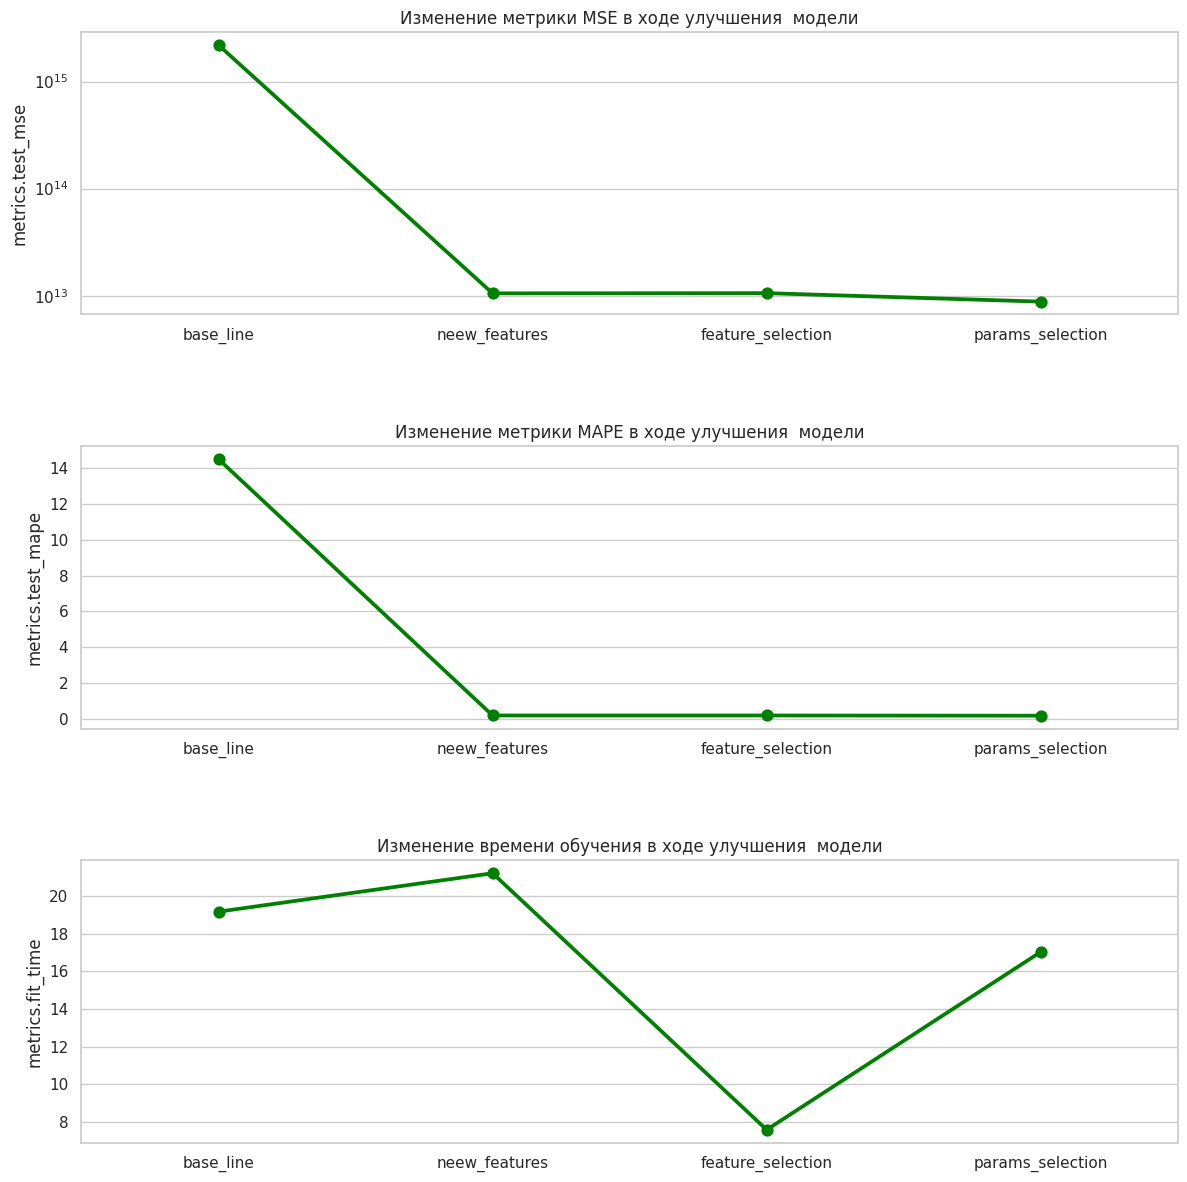

In [75]:
experiment_cleen = experiment_runs.dropna(subset=["metrics.test_mape"])

fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=1.6)
fig.set_size_inches(12, 13, forward=True)
xlabels = ["base_line", "neew_features", "feature_selection", "params_selection"]


sns.pointplot(
    data=experiment_cleen,
    x=xlabels,
    y=experiment_cleen["metrics.test_mse"],
    ax=axs[0],
    c="g",
    markers="o",
)
axs[0].set_title("Изменение метрики MSE в ходе улучшения  модели")
axs[0].set_yscale("log")

sns.pointplot(
    data=experiment_cleen,
    x=xlabels,
    y=experiment_cleen["metrics.test_mape"],
    ax=axs[1],
    c="g",
    markers="o",
)
axs[1].set_title("Изменение метрики MAPE в ходе улучшения  модели")

sns.pointplot(
    data=experiment_cleen,
    x=xlabels,
    y=experiment_cleen["metrics.fit_time"],
    ax=axs[2],
    c="g",
    markers="o",
)
axs[2].set_title("Изменение времени обучения в ходе улучшения  модели");

**Выводы**

В ходе работы модель улучшила свои показатели. 

При этом основным улучшением стала генерация новых признаков, последующие стадии улучшили работу, но не в такой большой степени. На последней стадии - после подбора оптимальных параметров, заметно увеличение времени обучения - это проявление изменения количества итераций модели до ≈ 900. Таким образом, если будет предъявлено требование о высокой скорости переобучения модели, стадию подбора параметров рекомендуется пересмотреть.